In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from numpy.random import seed
from tensorflow import set_random_seed
import os, shutil

import PIL
from PIL import Image
from IPython.display import display

from keras.optimizers import SGD 
from keras.optimizers import RMSprop
from keras.optimizers import adam
from keras import models
from keras import layers
from keras.callbacks import LearningRateScheduler
from keras.callbacks import TensorBoard

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2


from keras.applications.vgg16 import preprocess_input as vgg16_preprocessor
from keras.applications.xception import preprocess_input as xception_preprocessor
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor
from keras.applications.resnet50 import preprocess_input as resnet50_preprocessor
from keras.applications.inception_resnet_v2 import preprocess_input as inception_resnet_v2_preprocessor
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
# settle random seed
seed(1)
set_random_seed(2)

# Table of Contents
1. [Part1 Data Preprocessing](#P1)
1. [Part2 Model Training-Transfer Learning](#P2)
    1. [Model 1 InceptionResnetV2](#Model1)
        1. [Optimizer1: adam optimizer](#Optimizer1)
            1. [One Example of Other trials](#other1)
        1. [Optimizer2: SGD optimizer](#Optimizer2)
            1. [Step 1: Tuning Learning Rate for SGD](#Step1)
            1. [Step2: random search learing rate and momentum](#Step2)
            1. [best record using sgd, which beats the best the records of adam optimizer](#Best2)
            1. [Other trials](#other2)
    1. [Model 2: Inception_v3](#Model2)
    1. [Model 3: VGG16](#Model3)
    1. [Model 4: Xception](#Model4)
    1. [Model 5: Resnet50](#Model5)
1. [Part3 Plot the predictions for example images](#P3)

<a id='P1'></a>

# Part1 Data Preprocessing

In [18]:
labels_dir = r"C:\Users\wyr21\Desktop\labels\labels.csv"

train_df = pd.read_csv(labels_dir)
train_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## prepare data to fit for data augumentation using keras flow_from_directory

In [5]:
# split train/validation
seed = 1234
x_train_id, x_val_id, y_train_breed, y_val_breed = train_test_split(
    train_df['id'], train_df['breed'], test_size=0.2, stratify=np.array(train_df['breed']), random_state=seed)
train_df['split'] =train_df['id'].apply(lambda id: 'train' if id in x_train_id.values else 'val')

In [9]:
len(x_val_id),len(y_val_breed)

(2045, 2045)

In [10]:
len(x_train_id), len(y_train_breed)

(8177, 8177)

In [20]:
train_df.split.unique()

array(['val', 'train'], dtype=object)

In [25]:
# generate original path
train_origin_dir = "C:/Users/wyr21/Desktop/train/train/"
train_df['origin_path'] = train_df.apply( lambda x: ( train_origin_dir + x["id"] + ".jpg" ), axis=1 )

# generate target path
train_target_dir = "C:/Users/wyr21/Desktop/train/new/"
train_df['target_path'] = train_df.apply( lambda x: ( train_target_dir + x['split'] +'/' + x['breed']+ '/' + x["id"] + ".jpg" ), axis=1 )
#train_data = np.array([img_to_array(load_img(img, target_size=(dim, dim))) for img in train_df['image_path'].values.tolist()]).astype('float32')
#train_labels = train_df['breed']

In [37]:
# create new target directory
os.mkdir(train_target_dir)
train_target_train_dir = os.path.join(train_target_dir, 'train')
train_target_val_dir= os.path.join(train_target_dir,'val')
os.mkdir(train_target_train_dir)
os.mkdir(train_target_val_dir)

In [38]:
# create directory contains all train data
for breed in train_df['breed'].unique():
    train_breed_dir = os.path.join(train_target_train_dir, breed)
    os.mkdir(train_breed_dir)
# create directory contains all train data
for breed in train_df['breed'].unique():
    val_breed_dir = os.path.join(train_target_val_dir, breed)
    os.mkdir(val_breed_dir)

In [39]:
# copy image to new folders
for target_path, origin_path in zip(train_df['target_path'], train_df['origin_path']):
    shutil.copyfile(origin_path, target_path)

In [40]:
train_df[train_df['id']=='5ed432dc19e835ecacfbeea92c7cfc83']

,id,breed,split,origin_path,target_path
3829,5ed432dc19e835ecacfbeea92c7cfc83,affenpinscher,train,C:/Users/wyr21/Desktop/train/train/5ed432dc19e...,C:/Users/wyr21/Desktop/train/new/train/affenpi...


In [2]:
train_dir = "C:/Users/wyr21/Desktop/train/new/train"
validation_dir = "C:/Users/wyr21/Desktop/train/new/val"

<a id='P2'></a>

# Part 2  Model Training-Transfer Learning

Because imagenet also contains animal images, such as dogs, we think the pre-trained models trained on imagenet might fit our data well. So we decide to use transfer learning and weights that trained on imagenets.

<a id='Model1'></a>

## Model 1 InceptionResnetV2

In [3]:
# Fixed for Dog Breeds classes
NUM_CLASSES = 120

# Fixed for color images
CHANNELS = 3

IMAGE_RESIZE = 399
POOLING = 'avg'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

In [4]:
conv_base_incepres = InceptionResNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3), pooling=POOLING)
conv_base_incepres.trainable = False
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
#cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [91]:
# freeze certain layers 
#for layer in conv_base_incepres.layers[:598]:
    #layer.trainable = False

In [14]:
# augument using preprocessors to make sure data is properly preprocessed to fit the pre-trained model
image_size = IMAGE_RESIZE

train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      preprocessing_function=inception_resnet_v2_preprocessor)

# validation data dont's do augmentation.
test_datagen = ImageDataGenerator(preprocessing_function=inception_resnet_v2_preprocessor)

train_generator = train_datagen.flow_from_directory(
        # target directory
        train_dir,
        # image resized
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        # we have 120 breeds, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Found 8177 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


<a id='Optimizer1'></a>

### Optimizer1: adam optimizer

### best record when using adam optimizer

In [7]:
model = models.Sequential()
model.add(conv_base_incepres)
model.add(layers.Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam(),
              metrics=['acc'])

In [8]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=STEPS_PER_EPOCH_VALIDATION,
      verbose=2,
      callbacks=[cb_early_stopper])

Epoch 1/100
 - 41s - loss: 4.7365 - acc: 0.0570 - val_loss: 4.4225 - val_acc: 0.2340
Epoch 2/100
 - 25s - loss: 4.2346 - acc: 0.2260 - val_loss: 4.0006 - val_acc: 0.5630
Epoch 3/100
 - 28s - loss: 3.7162 - acc: 0.4690 - val_loss: 3.6040 - val_acc: 0.7471
Epoch 4/100
 - 27s - loss: 3.2322 - acc: 0.5990 - val_loss: 3.1937 - val_acc: 0.8200
Epoch 5/100
 - 27s - loss: 2.8390 - acc: 0.6540 - val_loss: 2.8396 - val_acc: 0.8847
Epoch 6/100
 - 28s - loss: 2.4313 - acc: 0.7280 - val_loss: 2.5250 - val_acc: 0.8760
Epoch 7/100
 - 27s - loss: 2.1608 - acc: 0.7370 - val_loss: 2.2233 - val_acc: 0.8931
Epoch 8/100
 - 28s - loss: 1.8110 - acc: 0.7930 - val_loss: 1.9609 - val_acc: 0.9060
Epoch 9/100
 - 27s - loss: 1.5438 - acc: 0.8080 - val_loss: 1.7787 - val_acc: 0.9005
Epoch 10/100
 - 29s - loss: 1.3977 - acc: 0.8140 - val_loss: 1.5554 - val_acc: 0.9220
Epoch 11/100
 - 28s - loss: 1.2047 - acc: 0.8270 - val_loss: 1.4014 - val_acc: 0.9270
Epoch 12/100
 - 29s - loss: 1.1605 - acc: 0.8080 - val_loss: 1.

Epoch 97/100
 - 29s - loss: 0.3733 - acc: 0.8840 - val_loss: 0.2995 - val_acc: 0.9238
Epoch 98/100
 - 30s - loss: 0.3508 - acc: 0.8880 - val_loss: 0.2872 - val_acc: 0.9300
Epoch 99/100
 - 27s - loss: 0.3783 - acc: 0.8883 - val_loss: 0.2342 - val_acc: 0.9429
Epoch 100/100
 - 29s - loss: 0.3663 - acc: 0.8880 - val_loss: 0.2915 - val_acc: 0.9290


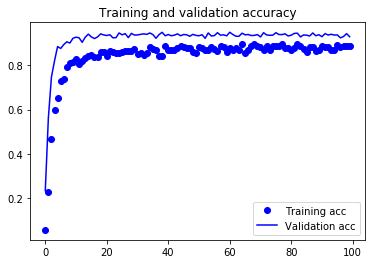

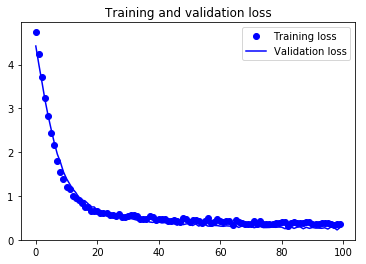

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
print('train_acc:',round(max(acc)*100,3), '/',acc.index(max(acc))+1)
print('val_acc:', round(max(val_acc)*100,3), '/',val_acc.index(max(val_acc))+1)
print('train_loss:',round(min(loss),3), '/',loss.index(min(loss))+1)
print('val_loss:', round(min(val_loss),3), '/',val_loss.index(min(val_loss))+1)

train_acc: 89.8 / 83
val_acc: 94.921 / 61
train_loss: 0.332 / 83
val_loss: 0.234 / 99


<a id='other1'></a>

### One Example of Other trials

In [93]:
model = models.Sequential()
model.add(conv_base_incepres)
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=adam(),
              metrics=['acc'])

In [94]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
      epochs=200,
      validation_data=validation_generator,
      validation_steps=STEPS_PER_EPOCH_VALIDATION,
      verbose=2,
      callbacks=[cb_early_stopper])

Epoch 1/200
 - 112s - loss: 3.4832 - acc: 0.2860 - val_loss: 3.6667 - val_acc: 0.3990
Epoch 2/200
 - 18s - loss: 2.2045 - acc: 0.4660 - val_loss: 2.3197 - val_acc: 0.4402
Epoch 3/200
 - 38s - loss: 1.5901 - acc: 0.5773 - val_loss: 2.5573 - val_acc: 0.4450
Epoch 4/200
 - 37s - loss: 1.4660 - acc: 0.5810 - val_loss: 2.3497 - val_acc: 0.4760
Epoch 5/200
 - 37s - loss: 1.2923 - acc: 0.6510 - val_loss: 1.8442 - val_acc: 0.5704
Epoch 6/200
 - 38s - loss: 1.2538 - acc: 0.6270 - val_loss: 1.2145 - val_acc: 0.6780
Epoch 7/200
 - 37s - loss: 1.1957 - acc: 0.6450 - val_loss: 1.2860 - val_acc: 0.6540
Epoch 8/200
 - 39s - loss: 1.2503 - acc: 0.6480 - val_loss: 1.0795 - val_acc: 0.7030
Epoch 9/200
 - 36s - loss: 1.1862 - acc: 0.6730 - val_loss: 1.0332 - val_acc: 0.7323
Epoch 10/200
 - 38s - loss: 1.1023 - acc: 0.6680 - val_loss: 1.0669 - val_acc: 0.7090
Epoch 11/200
 - 36s - loss: 1.0875 - acc: 0.6819 - val_loss: 1.0437 - val_acc: 0.6984
Epoch 12/200
 - 38s - loss: 0.8231 - acc: 0.7510 - val_loss: 1

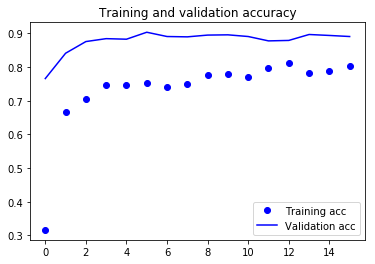

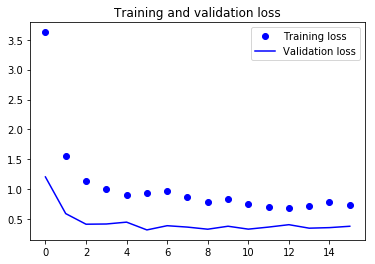

In [71]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [72]:
print('train_acc:',round(max(acc)*100,3), '/',acc.index(max(acc))+1)
print('val_acc:', round(max(val_acc)*100,3), '/',val_acc.index(max(val_acc))+1)
print('train_loss:',round(min(loss),3), '/',loss.index(min(loss))+1)
print('val_loss:', round(min(val_loss),3), '/',val_loss.index(min(val_loss))+1)

train_acc: 81.1 / 13
val_acc: 90.37 / 6
train_loss: 0.693 / 13
val_loss: 0.319 / 6


<a id='Optimizer2'></a>

### Optimizer2: SGD optimizer

<a id='Step1'></a>

### Step 1: Tuning Learning Rate for SGD

In [8]:
image_size = IMAGE_RESIZE

train_datagen = ImageDataGenerator(
      preprocessing_function=inception_resnet_v2_preprocessor)

test_datagen = ImageDataGenerator(preprocessing_function=inception_resnet_v2_preprocessor)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Found 8177 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


In [10]:
lr = list(10 ** np.random.uniform(-2, 0, 15))

In [13]:
def lr_tune(lrates, epochs):
    acc_max_lis=[]
    loss_min_lis=[]
    lrate_lis=[]


    for lrate in lrates:
        opt = SGD(lr=lrate)
        model = models.Sequential()
        model.add(conv_base_incepres)
        model.add(layers.Dense(120, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
        out = model.fit_generator(
                      train_generator,
                      steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
                      epochs=epochs,
                      validation_data=validation_generator,
                      validation_steps=STEPS_PER_EPOCH_VALIDATION,
                      verbose=2)
    
        acc_max_lis.append(max(out.history['val_acc']))
        loss_min_lis.append(min(out.history['val_loss']))
        lrate_lis.append(lrate)
        print('complete: ',lrates.index(lrate)+1, 'search')
    
    df_result =  pd.DataFrame([lrate_lis, acc_max_lis, loss_min_lis],index=['lr','acc','loss']).transpose()
    df_result.sort_values(by='acc', ascending=False, inplace=True)
    df_result.reset_index(inplace=True)
    
    return df_result

In [14]:
lr_tune(lr, 5)

Epoch 1/5
 - 22s - loss: 4.8693 - acc: 0.0090 - val_loss: 4.7038 - val_acc: 0.0201
Epoch 2/5
 - 12s - loss: 4.6501 - acc: 0.0200 - val_loss: 4.5165 - val_acc: 0.0840
Epoch 3/5
 - 13s - loss: 4.4738 - acc: 0.1018 - val_loss: 4.3010 - val_acc: 0.2254
Epoch 4/5
 - 12s - loss: 4.2760 - acc: 0.1870 - val_loss: 4.1047 - val_acc: 0.3570
Epoch 5/5
 - 12s - loss: 4.0773 - acc: 0.3290 - val_loss: 3.9420 - val_acc: 0.4265
complete:  0 search
Epoch 1/5
 - 23s - loss: 4.6846 - acc: 0.0430 - val_loss: 4.3274 - val_acc: 0.1873
Epoch 2/5
 - 12s - loss: 4.1354 - acc: 0.2660 - val_loss: 3.7887 - val_acc: 0.4860
Epoch 3/5
 - 12s - loss: 3.7282 - acc: 0.4690 - val_loss: 3.2552 - val_acc: 0.7153
Epoch 4/5
 - 12s - loss: 3.2396 - acc: 0.6360 - val_loss: 2.8018 - val_acc: 0.7860
Epoch 5/5
 - 12s - loss: 2.7874 - acc: 0.7089 - val_loss: 2.4199 - val_acc: 0.7979
complete:  1 search
Epoch 1/5
 - 25s - loss: 4.4270 - acc: 0.1530 - val_loss: 3.7993 - val_acc: 0.4201
Epoch 2/5
 - 12s - loss: 3.5016 - acc: 0.4350 -

,index,lr,acc,loss
0,2,0.252501,0.905820,1.076255
1,7,0.311364,0.902000,0.807524
2,3,0.384973,0.890000,0.663286
3,13,0.862344,0.886772,0.516855
4,12,0.202459,0.882540,1.414035
5,11,0.236449,0.880000,1.145891
6,8,0.971760,0.865000,0.887109
7,10,0.120291,0.828571,2.416401
8,1,0.123468,0.797884,2.419945
9,9,0.101897,0.794709,2.717516


first search lr in 10**-6 to 1, locate a better range from 0.01 to 1;seconde round search lr in 0.01-1, locate a better range from 0.1 to 1; 

<a id='Step2'></a>

### Step2: random search learing rate and momentum

In [21]:
param_grid = {
    'lrates': np.random.uniform(0.1, 0.2, 20),
    'second_para': np.random.uniform(0.9,1,20)}

In [22]:
param_grid

{'lrates': array([0.12619836, 0.12692071, 0.17662498, 0.19451714, 0.10078947,
        0.18035974, 0.17982088, 0.1947344 , 0.17029345, 0.1529397 ,
        0.12293411, 0.13226081, 0.14544353, 0.17430332, 0.18612508,
        0.18026493, 0.12561562, 0.18369168, 0.10847824, 0.17405799]),
 'second_para': array([0.94675214, 0.90702215, 0.92462309, 0.95254019, 0.9269409 ,
        0.91099321, 0.90525608, 0.99671294, 0.92640839, 0.98843357,
        0.9026623 , 0.91218763, 0.98377371, 0.94275574, 0.96425933,
        0.96436346, 0.90817674, 0.9999632 , 0.93753162, 0.90271696])}

In [25]:
def random_tune(params, epochs, optimizer, num_try):
    acc_max_lis=[]
    loss_min_lis=[]
    lrate_lis=[]
    second_para_lis = []
    
    i= 0

    while i<num_try:
        hypers =  {k: random.sample(list(v), 1) for k, v in param_grid.items()}
        if optimizer =='SGD':
            opt = SGD(lr=hypers['lrates'], momentum=hypers['second_para'])
        if optimizer =='RMSprop':
            opt = RMSprop(lr=hypers['lrates'], rho=hypers['second_para'])
       
        model = models.Sequential()
        model.add(conv_base_incepres)
        model.add(layers.Dense(120, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
        out = model.fit_generator(
                      train_generator,
                      steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
                      epochs=epochs,
                      validation_data=validation_generator,
                      validation_steps=STEPS_PER_EPOCH_VALIDATION,
                      verbose=2)
        
        acc_max_lis.append(max(out.history['val_acc']))
        loss_min_lis.append( min(out.history['val_loss']))
        lrate_lis.append(hypers['lrates'])
        second_para_lis.append(hypers['second_para'])
        
        print('complete: ',i+1 , 'search')
        i+=1
        
    df_result =  pd.DataFrame([lrate_lis, second_para_lis, acc_max_lis, loss_min_lis],index=['lr','second_para','acc','loss']).transpose()
    df_result.sort_values(by='acc', ascending=False, inplace=True)
    df_result.reset_index(inplace=True, drop=True)
    
    return df_result

In [26]:
random_tune(param_grid, 5, 'SGD', 15)

Epoch 1/5
 - 205s - loss: 4.1608 - acc: 0.2100 - val_loss: 2.2847 - val_acc: 0.6430
Epoch 2/5
 - 21s - loss: 1.7469 - acc: 0.6720 - val_loss: 0.5106 - val_acc: 0.8741
Epoch 3/5
 - 41s - loss: 0.9676 - acc: 0.7720 - val_loss: 0.4486 - val_acc: 0.8720
Epoch 4/5
 - 38s - loss: 0.8991 - acc: 0.7920 - val_loss: 0.5382 - val_acc: 0.8624
Epoch 5/5
 - 41s - loss: 0.8536 - acc: 0.8050 - val_loss: 0.4632 - val_acc: 0.8860
complete:  0 search
Epoch 1/5
 - 220s - loss: 4.1577 - acc: 0.2170 - val_loss: 2.1259 - val_acc: 0.7058
Epoch 2/5
 - 27s - loss: 1.4761 - acc: 0.7142 - val_loss: 0.5481 - val_acc: 0.8520
Epoch 3/5
 - 41s - loss: 0.8809 - acc: 0.7750 - val_loss: 0.5109 - val_acc: 0.8698
Epoch 4/5
 - 44s - loss: 0.9326 - acc: 0.7800 - val_loss: 0.5517 - val_acc: 0.8720
Epoch 5/5
 - 41s - loss: 0.8493 - acc: 0.8160 - val_loss: 0.4956 - val_acc: 0.8804
complete:  1 search
Epoch 1/5
 - 236s - loss: 4.1676 - acc: 0.1920 - val_loss: 2.3847 - val_acc: 0.5910
Epoch 2/5
 - 25s - loss: 1.7160 - acc: 0.674

,lr,second_para,acc,loss
0,[0.15293970003731822],[0.9070221451794342],0.902645,0.345246
1,[0.10078947191219727],[0.942755736365718],0.901587,0.356301
2,[0.12561562032003915],[0.905256083791415],0.901587,0.350621
3,[0.15293970003731822],[0.9269409014648623],0.9,0.384474
4,[0.12692070924446625],[0.9026623029861273],0.899,0.311226
5,[0.13226080533359527],[0.9109932065258529],0.898413,0.336487
6,[0.17029345260565862],[0.9026623029861273],0.898,0.334889
7,[0.13226080533359527],[0.9081767447192606],0.897,0.348427
8,[0.1947343991834089],[0.983773707863622],0.888,0.54189
9,[0.15293970003731822],[0.9375316195214913],0.886,0.4486


learning rate between 0.1 to 0.2，then find the best combination of momentum and initial learning rate, which is lr=0.15, momentum=0.9

<a id='Best2'></a>

### best record using sgd, which beats the best the records of adam optimizer.

In [10]:
model = models.Sequential()
model.add(conv_base_incepres)
model.add(layers.Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=False),
              metrics=['acc'])

In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=STEPS_PER_EPOCH_VALIDATION,
      verbose=2,
      callbacks=[cb_early_stopper])

Epoch 1/100
 - 45s - loss: 4.6275 - acc: 0.1010 - val_loss: 4.0952 - val_acc: 0.4420
Epoch 2/100
 - 27s - loss: 3.5493 - acc: 0.4290 - val_loss: 2.7865 - val_acc: 0.8000
Epoch 3/100
 - 30s - loss: 2.2167 - acc: 0.6500 - val_loss: 1.6828 - val_acc: 0.8751
Epoch 4/100
 - 29s - loss: 1.4212 - acc: 0.7380 - val_loss: 1.0484 - val_acc: 0.8860
Epoch 5/100
 - 29s - loss: 1.0225 - acc: 0.7710 - val_loss: 0.6923 - val_acc: 0.9249
Epoch 6/100
 - 30s - loss: 0.7744 - acc: 0.8240 - val_loss: 0.5562 - val_acc: 0.9200
Epoch 7/100
 - 29s - loss: 0.7072 - acc: 0.8230 - val_loss: 0.4565 - val_acc: 0.9407
Epoch 8/100
 - 30s - loss: 0.7095 - acc: 0.8130 - val_loss: 0.4361 - val_acc: 0.9290
Epoch 9/100
 - 30s - loss: 0.6150 - acc: 0.8329 - val_loss: 0.4033 - val_acc: 0.9175
Epoch 10/100
 - 31s - loss: 0.6228 - acc: 0.8280 - val_loss: 0.3788 - val_acc: 0.9200
Epoch 11/100
 - 30s - loss: 0.6240 - acc: 0.8290 - val_loss: 0.3478 - val_acc: 0.9418
Epoch 12/100
 - 31s - loss: 0.5653 - acc: 0.8490 - val_loss: 0.

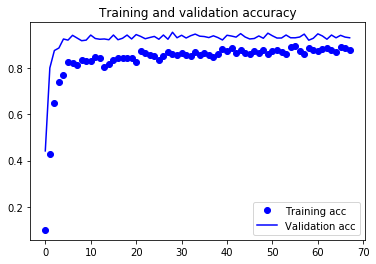

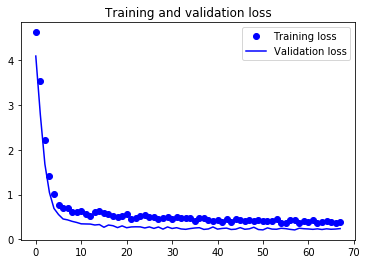

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
print('train_acc:',round(max(acc)*100,3), '/',acc.index(max(acc))+1)
print('val_acc:', round(max(val_acc)*100,3), '/',val_acc.index(max(val_acc))+1)
print('train_loss:',round(min(loss),3), '/',loss.index(min(loss))+1)
print('val_loss:', round(min(val_loss),3), '/',val_loss.index(min(val_loss))+1)

train_acc: 89.3 / 56
val_acc: 95.4 / 29
train_loss: 0.369 / 55
val_loss: 0.212 / 58


<a id='other2'></a>

### Other trials

In [39]:
def lr_schedule(val_loss):
    lrate = 0.1
    if val_loss<0.26:
        lrate = 0.001 
    return lrate

In [45]:
from keras.optimizers import RMSprop

In [7]:
model = models.Sequential()
model.add(conv_base_incepres)
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.01, decay=1e-6),
              metrics=['acc'])

In [8]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=STEPS_PER_EPOCH_VALIDATION,
      verbose=2,
      callbacks=[cb_early_stopper])

Epoch 1/100
 - 27s - loss: 11.3574 - acc: 0.0620 - val_loss: 9.8304 - val_acc: 0.1700
Epoch 2/100
 - 16s - loss: 10.6734 - acc: 0.1710 - val_loss: 9.1430 - val_acc: 0.3540
Epoch 3/100
 - 18s - loss: 9.7208 - acc: 0.2580 - val_loss: 8.2098 - val_acc: 0.4487
Epoch 4/100
 - 18s - loss: 9.2655 - acc: 0.3270 - val_loss: 8.3011 - val_acc: 0.4530
Epoch 5/100
 - 18s - loss: 9.5201 - acc: 0.3040 - val_loss: 8.4111 - val_acc: 0.4476
Epoch 6/100
 - 18s - loss: 9.2780 - acc: 0.3310 - val_loss: 7.6213 - val_acc: 0.5090
Epoch 7/100
 - 17s - loss: 8.9747 - acc: 0.3540 - val_loss: 8.0720 - val_acc: 0.4741
Epoch 8/100
 - 18s - loss: 9.1407 - acc: 0.3380 - val_loss: 8.0484 - val_acc: 0.4810
Epoch 9/100
 - 17s - loss: 8.6420 - acc: 0.3645 - val_loss: 8.0666 - val_acc: 0.4677
Epoch 10/100
 - 18s - loss: 9.0311 - acc: 0.3630 - val_loss: 8.1689 - val_acc: 0.4680
Epoch 11/100
 - 18s - loss: 8.8667 - acc: 0.3820 - val_loss: 8.0057 - val_acc: 0.4847
Epoch 12/100
 - 18s - loss: 8.5725 - acc: 0.3920 - val_loss: 

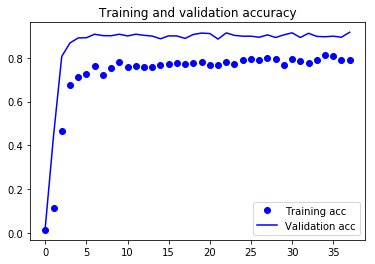

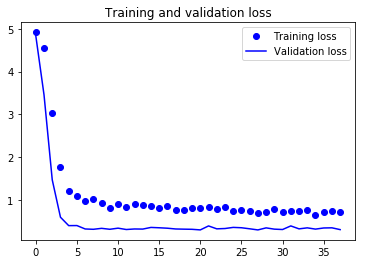

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
print('train_acc:',round(max(acc)*100,3), '/',acc.index(max(acc))+1)
print('val_acc:', round(max(val_acc)*100,3), '/',val_acc.index(max(val_acc))+1)
print('train_loss:',round(min(loss),3), '/',loss.index(min(loss))+1)
print('val_loss:', round(min(val_loss),3), '/',val_loss.index(min(val_loss))+1)

train_acc: 81.1 / 35
val_acc: 91.7 / 38
train_loss: 0.657 / 35
val_loss: 0.301 / 28


## The followings are trianls at the beginning to decide which pre-trained model is the best fit to our data. All trained with adding only fc classification layer, and other hyperparameters are kept the same. We picked up InceptionResnetV2 as the result of this process.

<a id='Model2'></a>

### Model 2: Inception_v3

In [115]:
NUM_CLASSES = 120

CHANNELS = 3

IMAGE_RESIZE = 299
POOLING = 'avg'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 10

STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

In [116]:
conv_base_incep = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3), pooling=POOLING)
conv_base_incep.trainable = False
cb_early_stopper = EarlyStopping(monitor = 'val_acc', patience = EARLY_STOP_PATIENCE)

87916544/87910968 [==============================] - 16s 0us/step


In [117]:
image_size = IMAGE_RESIZE

train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      preprocessing_function=inception_v3_preprocessor)

test_datagen = ImageDataGenerator(preprocessing_function=inception_v3_preprocessor)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Found 8177 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


In [122]:
model = models.Sequential()
model.add(conv_base_incep)
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam(),
              metrics=['acc'])

In [123]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=STEPS_PER_EPOCH_VALIDATION,
      verbose=2,
      callbacks=[cb_early_stopper])

Epoch 1/100
 - 33s - loss: 4.7233 - acc: 0.0430 - val_loss: 4.2488 - val_acc: 0.1810
Epoch 2/100
 - 21s - loss: 4.2563 - acc: 0.1652 - val_loss: 3.5697 - val_acc: 0.4420
Epoch 3/100
 - 24s - loss: 3.6191 - acc: 0.3150 - val_loss: 2.7811 - val_acc: 0.5450
Epoch 4/100
 - 24s - loss: 3.0047 - acc: 0.4340 - val_loss: 2.0170 - val_acc: 0.6810
Epoch 5/100
 - 23s - loss: 2.5081 - acc: 0.4990 - val_loss: 1.5051 - val_acc: 0.7407
Epoch 6/100
 - 25s - loss: 2.2407 - acc: 0.5280 - val_loss: 1.1066 - val_acc: 0.7770
Epoch 7/100
 - 24s - loss: 1.8408 - acc: 0.5800 - val_loss: 0.8708 - val_acc: 0.8000
Epoch 8/100
 - 25s - loss: 1.7008 - acc: 0.5870 - val_loss: 0.7672 - val_acc: 0.8140
Epoch 9/100
 - 24s - loss: 1.5610 - acc: 0.6360 - val_loss: 0.6526 - val_acc: 0.8381
Epoch 10/100
 - 25s - loss: 1.5130 - acc: 0.6185 - val_loss: 0.6354 - val_acc: 0.8330
Epoch 11/100
 - 23s - loss: 1.1891 - acc: 0.6980 - val_loss: 0.5270 - val_acc: 0.8519
Epoch 12/100
 - 25s - loss: 1.1959 - acc: 0.6770 - val_loss: 0.

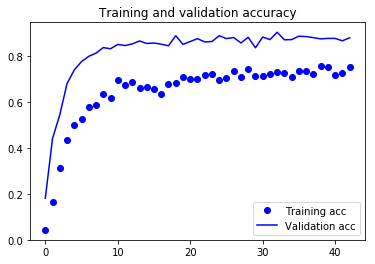

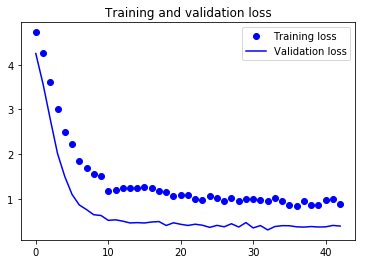

In [124]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [125]:
print(max(acc), acc.index(max(acc))+1)
print(max(val_acc), val_acc.index(max(val_acc))+1)

0.7560000061988831 39
0.9050000011920929 33


<a id='Model3'></a>

### Model 3: VGG16

In [130]:
NUM_CLASSES = 120

CHANNELS = 3

IMAGE_RESIZE = 224
POOLING = 'avg'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 10

STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

In [131]:
conv_base_vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3), pooling=POOLING)
conv_base_vgg16.trainable = False
cb_early_stopper = EarlyStopping(monitor = 'val_acc', patience = EARLY_STOP_PATIENCE)

In [132]:
image_size = IMAGE_RESIZE

train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      preprocessing_function=vgg16_preprocessor)

test_datagen = ImageDataGenerator(preprocessing_function=vgg16_preprocessor)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Found 8177 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


In [133]:
model = models.Sequential()
model.add(conv_base_vgg16)
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam(),
              metrics=['acc'])

In [134]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=STEPS_PER_EPOCH_VALIDATION,
      verbose=2,
      callbacks=[cb_early_stopper])

Epoch 1/100
 - 23s - loss: 10.0900 - acc: 0.0260 - val_loss: 8.7849 - val_acc: 0.0470
Epoch 2/100
 - 10s - loss: 6.4276 - acc: 0.0350 - val_loss: 5.3240 - val_acc: 0.0760
Epoch 3/100
 - 15s - loss: 4.7240 - acc: 0.0540 - val_loss: 4.3026 - val_acc: 0.0995
Epoch 4/100
 - 14s - loss: 4.4010 - acc: 0.0660 - val_loss: 4.0959 - val_acc: 0.1330
Epoch 5/100
 - 14s - loss: 4.0980 - acc: 0.1200 - val_loss: 3.8293 - val_acc: 0.1704
Epoch 6/100
 - 15s - loss: 3.8328 - acc: 0.1270 - val_loss: 3.4249 - val_acc: 0.2310
Epoch 7/100
 - 14s - loss: 3.5454 - acc: 0.2020 - val_loss: 3.1235 - val_acc: 0.2540
Epoch 8/100
 - 15s - loss: 3.2442 - acc: 0.2290 - val_loss: 2.9655 - val_acc: 0.3030
Epoch 9/100
 - 14s - loss: 2.9710 - acc: 0.2699 - val_loss: 2.6641 - val_acc: 0.3651
Epoch 10/100
 - 15s - loss: 2.7446 - acc: 0.3230 - val_loss: 2.4340 - val_acc: 0.3920
Epoch 11/100
 - 14s - loss: 2.4824 - acc: 0.3670 - val_loss: 2.2911 - val_acc: 0.4254
Epoch 12/100
 - 15s - loss: 2.3023 - acc: 0.3920 - val_loss: 2

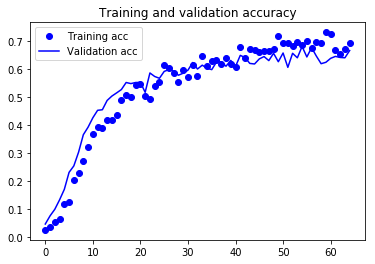

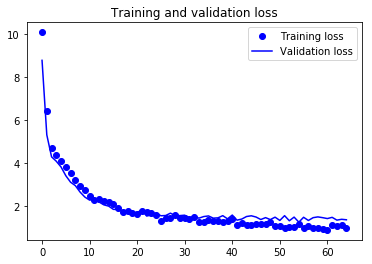

In [135]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [136]:
print(max(acc), acc.index(max(acc))+1)
print(max(val_acc), val_acc.index(max(val_acc))+1)

0.7300000011920929 60
0.679365077346721 55


<a id='Model4'></a>

### Model 4: Xception

In [137]:
NUM_CLASSES = 120

CHANNELS = 3

IMAGE_RESIZE = 299
POOLING = 'avg'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 10

STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

In [138]:
conv_base_xcep = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3), pooling=POOLING)
conv_base_xcep.trainable = False
cb_early_stopper = EarlyStopping(monitor = 'val_acc', patience = EARLY_STOP_PATIENCE)

In [139]:
image_size = IMAGE_RESIZE

train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      preprocessing_function=xception_preprocessor)

test_datagen = ImageDataGenerator(preprocessing_function=xception_preprocessor)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Found 8177 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


In [140]:
model = models.Sequential()
model.add(conv_base_xcep)
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam(),
              metrics=['acc'])

In [141]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=STEPS_PER_EPOCH_VALIDATION,
      verbose=2,
      callbacks=[cb_early_stopper])

Epoch 1/100
 - 37s - loss: 4.5681 - acc: 0.1050 - val_loss: 4.1227 - val_acc: 0.3210
Epoch 2/100
 - 24s - loss: 3.7985 - acc: 0.3400 - val_loss: 3.1715 - val_acc: 0.5890
Epoch 3/100
 - 27s - loss: 2.8802 - acc: 0.4840 - val_loss: 2.1895 - val_acc: 0.7513
Epoch 4/100
 - 28s - loss: 2.0436 - acc: 0.6250 - val_loss: 1.4965 - val_acc: 0.7860
Epoch 5/100
 - 28s - loss: 1.5470 - acc: 0.6620 - val_loss: 1.0246 - val_acc: 0.8455
Epoch 6/100
 - 29s - loss: 1.3177 - acc: 0.7040 - val_loss: 0.8273 - val_acc: 0.8370
Epoch 7/100
 - 28s - loss: 1.1892 - acc: 0.7030 - val_loss: 0.7096 - val_acc: 0.8476
Epoch 8/100
 - 28s - loss: 1.0616 - acc: 0.6950 - val_loss: 0.6055 - val_acc: 0.8680
Epoch 9/100
 - 27s - loss: 0.9734 - acc: 0.7384 - val_loss: 0.5583 - val_acc: 0.8698
Epoch 10/100
 - 28s - loss: 0.9269 - acc: 0.7580 - val_loss: 0.5480 - val_acc: 0.8690
Epoch 11/100
 - 27s - loss: 0.7901 - acc: 0.7910 - val_loss: 0.5347 - val_acc: 0.8741
Epoch 12/100
 - 28s - loss: 0.8343 - acc: 0.7690 - val_loss: 0.

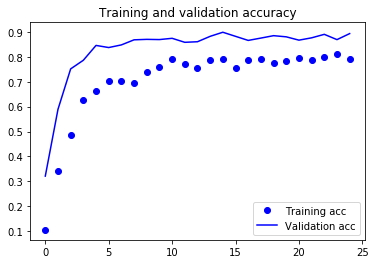

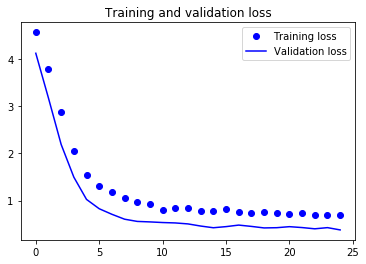

In [142]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [143]:
print(max(acc), acc.index(max(acc))+1)
print(max(val_acc), val_acc.index(max(val_acc))+1)

0.8120000064373016 24
0.8984126959528241 15


<a id='Model5'></a>

### Model 5: Resnet50

In [20]:
NUM_CLASSES = 120

CHANNELS = 3

IMAGE_RESIZE = 350
RESNET50_POOLING_AVERAGE = 'avg'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 10

STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

BATCH_SIZE_TESTING = 1

In [27]:
conv_base_res =ResNet50(weights='imagenet',
                        pooling = RESNET50_POOLING_AVERAGE,
                        include_top=False,
                        input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3))
conv_base_res.trainable = False
cb_early_stopper = EarlyStopping(monitor = 'val_acc', patience = EARLY_STOP_PATIENCE)

In [23]:
image_size = IMAGE_RESIZE

train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      preprocessing_function=resnet50_preprocessor)

test_datagen = ImageDataGenerator(preprocessing_function=resnet50_preprocessor)

train_generator = train_datagen.flow_from_directory(
       train_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
       class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Found 8177 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


In [29]:
model = models.Sequential()
model.add(conv_base_res)
model.add(layers.Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam(),
              metrics=['acc'])

In [30]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=STEPS_PER_EPOCH_VALIDATION,
      verbose=2,
      callbacks=[cb_early_stopper])

Epoch 1/100
 - 28s - loss: 5.0148 - acc: 0.0190 - val_loss: 4.4721 - val_acc: 0.0508
Epoch 2/100
 - 19s - loss: 4.4321 - acc: 0.0760 - val_loss: 3.8811 - val_acc: 0.1620
Epoch 3/100
 - 21s - loss: 3.8284 - acc: 0.1830 - val_loss: 3.3138 - val_acc: 0.3070
Epoch 4/100
 - 21s - loss: 3.4593 - acc: 0.2530 - val_loss: 2.9426 - val_acc: 0.3788
Epoch 5/100
 - 21s - loss: 3.0581 - acc: 0.3460 - val_loss: 2.5863 - val_acc: 0.4650
Epoch 6/100
 - 20s - loss: 2.8111 - acc: 0.3690 - val_loss: 2.2841 - val_acc: 0.5280
Epoch 7/100
 - 21s - loss: 2.5390 - acc: 0.4460 - val_loss: 2.0782 - val_acc: 0.5500
Epoch 8/100
 - 20s - loss: 2.3081 - acc: 0.4853 - val_loss: 1.9097 - val_acc: 0.5873
Epoch 9/100
 - 21s - loss: 2.0000 - acc: 0.5660 - val_loss: 1.7347 - val_acc: 0.6240
Epoch 10/100
 - 20s - loss: 1.8708 - acc: 0.5830 - val_loss: 1.6468 - val_acc: 0.6370
Epoch 11/100
 - 21s - loss: 1.7598 - acc: 0.6090 - val_loss: 1.5717 - val_acc: 0.6370
Epoch 12/100
 - 20s - loss: 1.7330 - acc: 0.6070 - val_loss: 1.

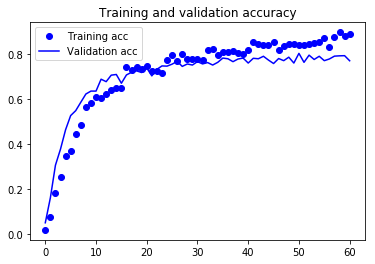

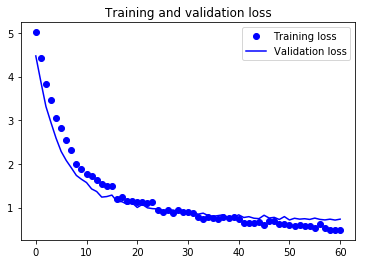

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
print(max(acc), acc.index(max(acc))+1)
print(max(val_acc), val_acc.index(max(val_acc))+1)

0.8990000009536743 59
0.8049999952316285 51


<a id='P3'></a>

# Part3 Plot the predictions for example images

In [27]:
train_df['index'] = train_df.index
train_df['rank'] = train_df.groupby('breed')['index'].rank(method='dense')

In [29]:
def read_img(path, size):
    img = image.load_img(path, target_size=size)
    img = image.img_to_array(img)
    return img

In [31]:
train_origin_dir = "C:/Users/wyr21/Desktop/train/train/"
train_df['origin_path'] = train_df.apply( lambda x: ( train_origin_dir + x["id"] + ".jpg" ), axis=1 )

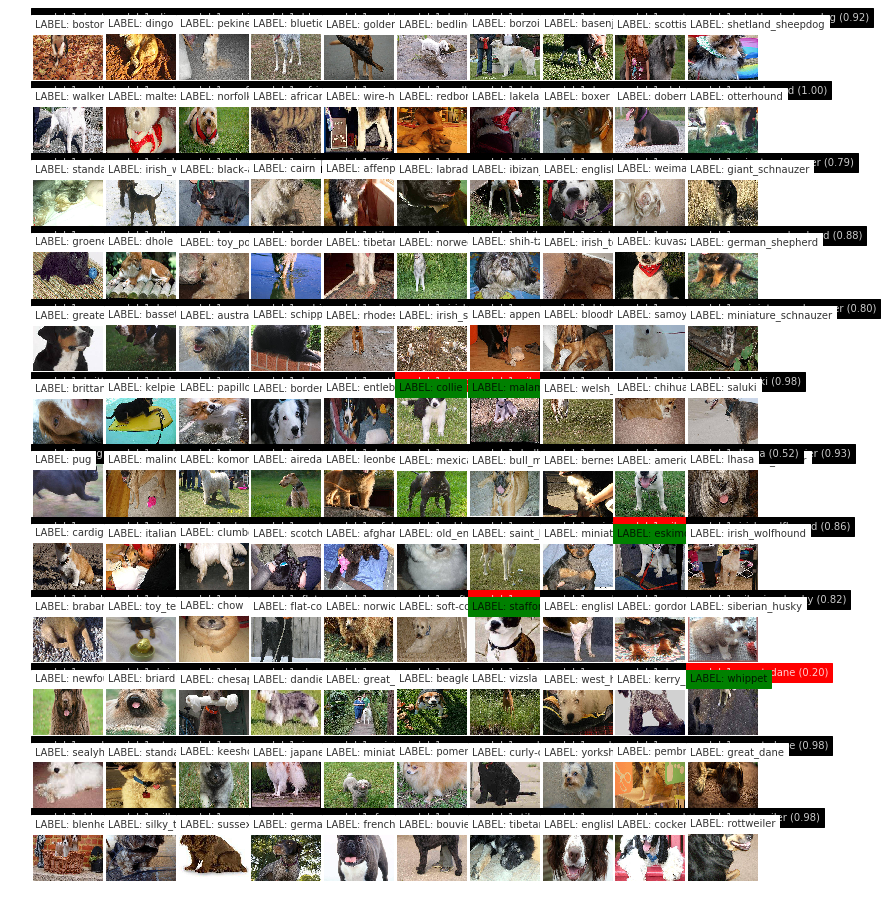

In [34]:
NUM_CLASSES = 120

j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(train_df.loc[train_df['rank'] == 1, ['id', 'breed']].values):
    ax = grid[i]
    img = read_img(train_df.loc[train_df['rank']==1,'origin_path'].values[i], (399,399))
    ax.imshow(img / 255.)
    x = inception_resnet_v2_preprocessor(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    classes = preds.argmax(axis=-1)
    preds_label = sorted(train_df.breed.unique())[classes[0]] 
    if preds_label==breed:
        ax.text(10, 50, 'model_1: %s (%.2f)' % (preds_label , preds.max()), color='w', backgroundcolor='k', alpha=0.8)
        ax.text(10, 250, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    else:
        ax.text(10, 50, 'model_1: %s (%.2f)' % (preds_label , preds.max()), color='w', backgroundcolor='r', alpha=0.8)
        ax.text(10, 250, 'LABEL: %s' % breed, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
plt.show()